In [1]:
%pylab inline
from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm
from helpers.dataTransfer import saveFullDataToRemote

Populating the interactive namespace from numpy and matplotlib


# Data Saving Info

In [1]:
remotePath = "C:/Users/hatla/Downloads"
sampleName = "Q1"

# Configuring the channels

The data in this notebook was taken with a wiring diagram similar to the above. The QICK has eight RF DACs which can be configured in multiple ways. Using the QICK, two RF DACs are needed to control the qubit and its readout resonator, respectively. Also, the qubit control pulses (< 6 GHz) were directly synthesized without the use of an analog mixer. Note that the QICK RF board was not used for these measurements, only the ZCU111 evaluation board plus the analog components specified in the diagram.

In [2]:
# Load bitstream with custom overlay
soc = QickSoc()
soc.set_nyquist(ch=6,nqz=1) #Readout_I
soc.set_nyquist(ch=7,nqz=1) #Readout_Q
soc.set_nyquist(ch=3,nqz=2) #Qubit_drive

hw_cfg={"res_ch_I":6,
        "res_ch_Q":7,
        "Qubit_ch":3,
        
       }

resetting clocks: 204.8
Not all DAC and ADC PLLs are locked. You may want to repeat the initialization of the QickSoc.


# TOF Measurement

Measures the "time of flight" of the measurement pulse. The time of flight is the time at which the measurement pulse appears in the ADC buffer. We only want to start capturing data from this point in time onwards. We store this time of flight in the parameter <code> readout_cfg["adc_trig_offset"] </code>.

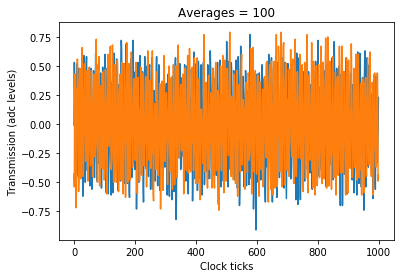

In [14]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        cfg["adc_lengths"]=[cfg["readout_length"]]*2          #add length of adc acquisition to config
        cfg["adc_freqs"]=[soc.adcfreq(cfg["frequency"])]*2   #add frequency of adc dds to config
        
        self.add_pulse(ch=cfg["res_ch_I"], name="measure", style="const", length=cfg["pulse_length"])  #add a constant pulse to the pulse library
        self.add_pulse(ch=cfg["res_ch_Q"], name="measure", style="const", length=cfg["pulse_length"])  #add a constant pulse to the pulse library
        self.add_pulse(ch=cfg["Qubit_ch"], name="measure", style="const", length=cfg["pulse_length"])  #add a constant pulse to the pulse library
#         self.add_pulse(ch=self.cfg["res_ch_Q"], name="measure", style="arb", 
#                        idata=gauss(mu=cfg["sigma"]*16*4/2,si=cfg["sigma"]*16,length=4*cfg["sigma"]*16,maxv=2**15-1))
        
#         self.add_pulse(ch=self.cfg["res_ch_Q"], name="measure", style="arb", 
#                        idata=np.array([2**15-1]*16*100))
        self.freq=soc.freq2reg(soc.adcfreq(cfg["frequency"]))  # convert frequency to dac frequency (ensuring it is an available adc frequency)
        self.Q_freq=soc.freq2reg(soc.adcfreq(cfg["qubit_frequency"]))  # convert frequency to dac frequency (ensuring it is an available adc frequency)
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        cfg=self.cfg   
        self.trigger_adc(adc1=1, adc2=0, adc_trig_offset=cfg["adc_trig_offset"])  # trigger the adc acquisition
        self.pulse(ch=cfg["res_ch_I"], name="measure", freq=self.freq, phase=0, gain=cfg["pulse_gain"], mode=1, t=0, play=True)
        self.pulse(ch=cfg["res_ch_Q"], name="measure", freq=self.freq, phase=deg2reg(-90), gain=cfg["pulse_gain"], mode=1, t=0, play=True) 
        self.pulse(ch=cfg["Qubit_ch"], name="measure", freq=self.Q_freq, phase=0, gain=cfg["pulse_gain"], mode=0, t=0, play=True) 
        self.marker(t=100, t1=1, short=False)
#         self.marker(t=100, t2=1, short=False)
        self.sync_all(soc.us2cycles(self.cfg["relax_delay"]))  # sync all channels

expt_config={
        "reps":1, # --Fixed
        "pulse_length":60000, # [Clock ticks]
        "readout_length":1000, # [Clock ticks]
        "pulse_gain":12767, # [DAC units]
        "frequency": 50, # [MHz]
        "adc_trig_offset": 0, # [Clock ticks]
        "soft_avgs":100,
        "relax_delay": 0,
        "sigma": soc.us2cycles(0.025),
        "qubit_frequency": 4200
       }

config={**hw_cfg,**expt_config}
prog =LoopbackProgram(config)
adc1, adc2 = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)

# Plot results.
subplot(111, title=f"Averages = {config['soft_avgs']}", xlabel="Clock ticks", ylabel="Transmission (adc levels)")
plot(adc1[0], label="I value; ADC 0")
plot(adc1[1], label="Q value; ADC 0")


In [127]:
cycles2us(60000)

156.25